In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os
import struct
import pywt

sys.path.append(os.path.join(os.getcwd(), 'EC'))
import constants
import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(constants)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)

from Func_read_data import *
from constants import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *

In [ ]:
"""TO DO
- process 16 and 26 m data fast 2024
- run Eddypro all heights
- choose events of BS and no BS
- plot events slowdata and fluxes in heights
- make MO script  
- SPC processing scripts
"""

In [2]:

file='/home/engbers/Documents/PhD/EC_data_convert/converted/20240101_CSAT3TOWER/Tower_Anemo_All.csv'
fastdata=pd.read_csv(file, header=0, parse_dates=[1], index_col=1)
fastdata = fastdata.drop(columns=['Unnamed: 0'])
fastdata_renamed= fastdata.copy()
fastdata=fastdata.rename(columns={
    'U_1': 'Ux1', 
    'V_1': 'Uy1', 
    'W_1': 'Uz1', 
    'Ts_1': 'Ts1', 
    'U_2': 'Ux2', 
    'V_2': 'Uy2', 
    'W_2': 'Uz2', 
    'Ts_2': 'Ts2', 
    'status_1': 'diag_csat1', 
    'status_2': 'diag_csat2'
})



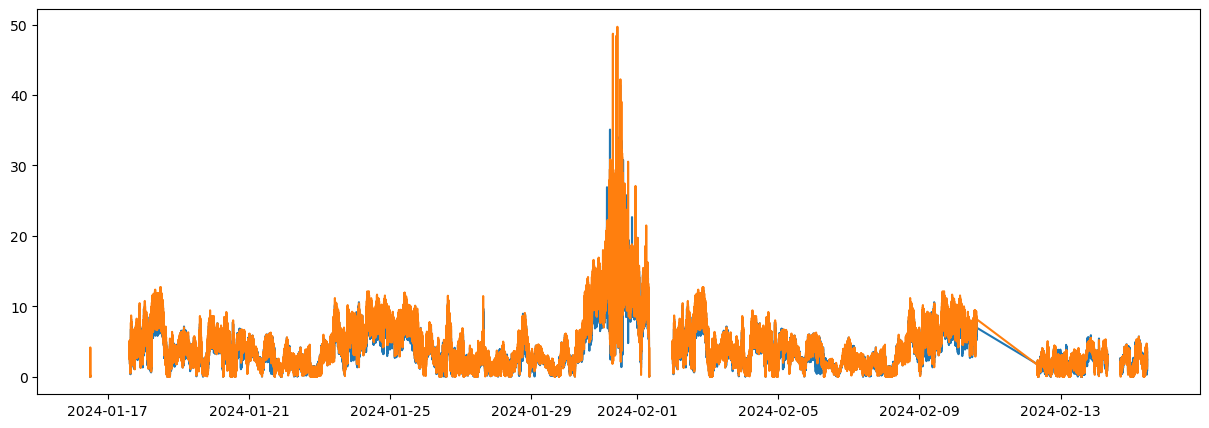

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(np.sqrt((fastdata['Ux1']**2+fastdata['Uy1']**2)), label='U1')
plt.plot(np.sqrt((fastdata['Ux2']**2+fastdata['Uy2']**2)), label='U2')

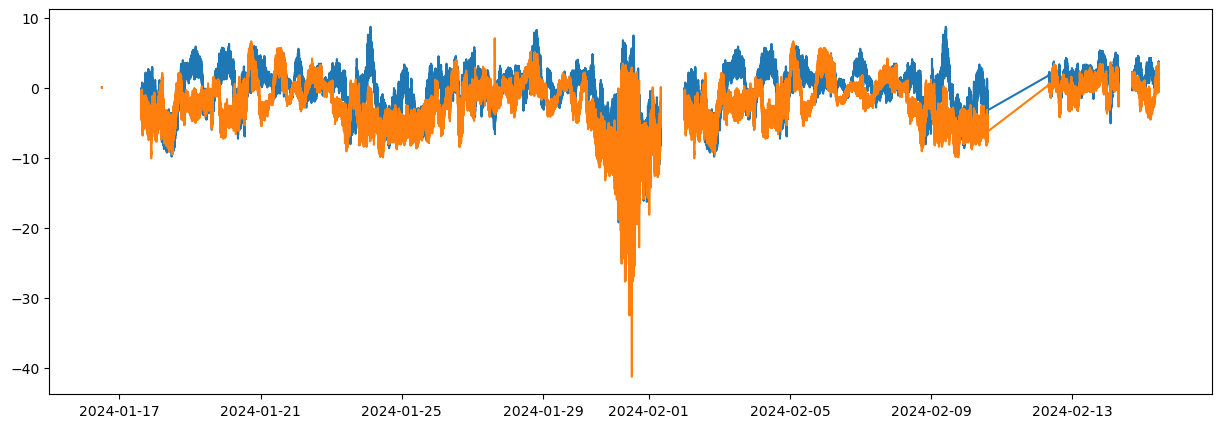

In [5]:
plt.figure(figsize=(15, 5))
plt.plot((fastdata['Uy1']), label='U1')
plt.plot((fastdata['Ux1']), label='U1')
# plt.plot(np.sqrt((fastdata['Ux2']**2+fastdata['Uy2']**2)), label='U2')

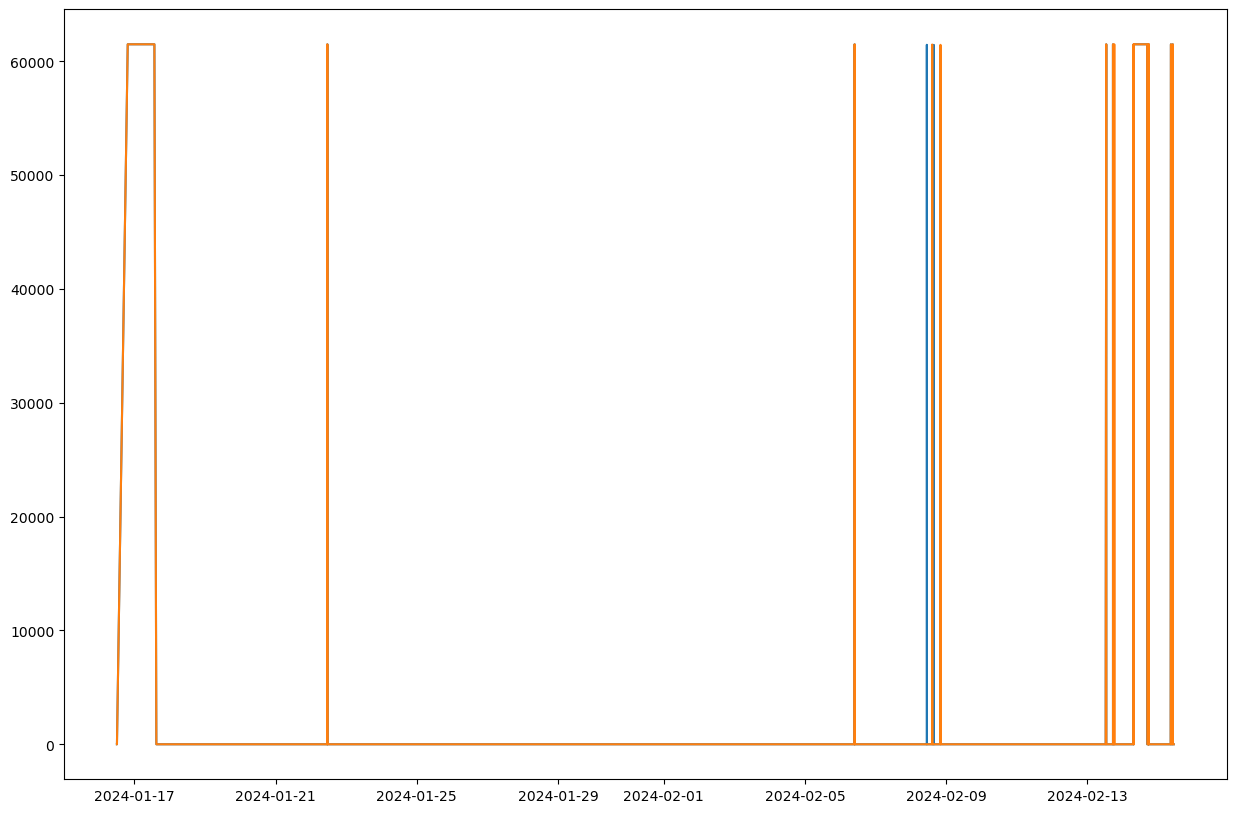

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(fastdata.index, fastdata['diag_csat1'], label='diag_csat1')
plt.plot(fastdata.index, fastdata['diag_csat2'], label='diag_csat2')

In [3]:
def save_despiked_data(fastdata, despiked_fastdata, output_folder, sensor):
    """
    Save the despiked fast data to .dat file per hour
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Ensure the timestamp is a datetime object
    if not pd.api.types.is_datetime64_any_dtype(despiked_fastdata.index):
        despiked_fastdata.index = pd.to_datetime(despiked_fastdata.index)

    # Rename and select the desired columns
    save_fastdata = pd.DataFrame()
    if 'LI_H2Om' in despiked_fastdata.columns:
        save_fastdata[['Ux', 'Uy', 'Uz', 'Ts', 'LI_H2Om', 'LI_Pres']] = despiked_fastdata[
            ['Ux', 'Uy', 'Uz', 'Ts', 'LI_H2Om_corr', 'LI_Pres']]
    else:
        save_fastdata[['Ux', 'Uy', 'Uz', 'Ts']] = despiked_fastdata[
            ['Ux', 'Uy', 'Uz', 'Ts']]
    save_fastdata = save_fastdata[~save_fastdata.index.duplicated(keep='first')]
    save_fastdata = save_fastdata.resample('50ms').asfreq()

    # Group by hour
    for date, group in save_fastdata.groupby(pd.Grouper(freq='h')):
        print(len(group))
        print(f"Processing date: {date}")
        if len(group) == 72000:  # Check if the data consists of a full hour (100ms frequency, 36000 rows per hour)
            date_str = pd.to_datetime(date).strftime("%Y-%m-%d_%H%M")
            file_path = os.path.join(output_folder, f"{sensor}_Fastdata_proc_{date_str}.dat")

            # Add units as the second row
            # units_row = {col: fastdata.attrs['units'].get(col, '') for col in group.columns}
            # group_with_units = pd.concat([pd.DataFrame([units_row], index=['units']), group])

            # Save to .dat 
            group.to_csv(file_path, sep='\t', index=True, header=True)

            print(f"Data saved per hour in {file_path}")


In [4]:
"""DESPIKING AND CALIBRATION OF FASTDATA FOR CSAT 16 and 26 m"""
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='CSAT'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

fastdata_CSAT16 = pd.DataFrame()
fastdata_CSAT26 = pd.DataFrame()

# Assign columns and copy attributes
fastdata_CSAT16[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux1', 'Uy1', 'Uz1', 'Ts1', 'diag_csat1']]
fastdata_CSAT26[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux2', 'Uy2', 'Uz2', 'Ts2', 'diag_csat2']]

# Assign attributes (units) to each column
fastdata_CSAT16.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
fastdata_CSAT26.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
# """DESPIKE FASTDATA"""
# despiked_fastdata_CSAT16=despike_fast_MAD(fastdata_CSAT16, None, plim, 'CSAT16', plot_despike=False)
# """SAVE DESPIKED DATA"""
# output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/202401'
# save_despiked_data(fastdata_CSAT16, despiked_fastdata_CSAT16, output_folder, sensor)
"""DESPIKE FASTDATA"""
despiked_fastdata_CSAT26=despike_fast_MAD(fastdata_CSAT26, None, plim, 'CSAT26', plot_despike=False)
"""SAVE DESPIKED DATA"""
output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/202401'
save_despiked_data(fastdata_CSAT26, despiked_fastdata_CSAT26, output_folder, sensor)

None
Plausibility limits: Discarding 22 'w' records.
Plausibility limits: Discarding 416 'Ts' records.
diag_csat: Discarding 1778974 'CSAT' records.
Plausibility limits applied
Processing large dataset (%)
Spikes removed from Ux,Uy,Uz,Ts:17642
67616
Processing date: 2024-01-16 12:00:00
72000
Processing date: 2024-01-16 13:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/202401/CSAT_Fastdata_proc_2024-01-16_1300.dat
72000
Processing date: 2024-01-16 14:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/202401/CSAT_Fastdata_proc_2024-01-16_1400.dat
72000
Processing date: 2024-01-16 15:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/202401/CSAT_Fastdata_proc_2024-01-16_1500.dat
72000
Processing date: 2024-01-16 16:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/202401/CSAT_Fastdata_proc_2024-01-16_1600.dat
72000
Processing date: 2024-01-16 17:00:00
Data saved

In [ ]:
"""DESPIKING AND CALIBRATION OF FASTDATA FOR CSAT 16 and 26 m"""
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='CSAT'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""

# fastdata=read_data(folder, 'fast', sensor, start, end)
file_numbers_array = [i for i in range(9, 10, 1)]
for file_number in file_numbers_array:
    file_numbers = np.arange(file_number, file_number + 2).astype(int).astype(str)
    print(file_numbers)
    fastdata=read_data(folder, 'fast', sensor, start, end, file_numbers=file_numbers)

    fastdata_CSAT16 = pd.DataFrame()
    fastdata_CSAT26 = pd.DataFrame()

    # Assign columns and copy attributes
    fastdata_CSAT16[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux1', 'Uy1', 'Uz1', 'Ts1', 'diag_csat1']]
    fastdata_CSAT26[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux2', 'Uy2', 'Uz2', 'Ts2', 'diag_csat2']]

    # Assign attributes (units) to each column
    fastdata_CSAT16.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
    fastdata_CSAT26.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
    """DESPIKE FASTDATA"""
    despiked_fastdata_CSAT16=despike_fast_MAD(fastdata_CSAT16, None, plim, 'CSAT16', plot_despike=False)
    """SAVE DESPIKED DATA"""
    output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/20240{file_number}'
    save_despiked_data(fastdata_CSAT16, despiked_fastdata_CSAT16, output_folder, sensor)
    """DESPIKE FASTDATA"""
    despiked_fastdata_CSAT26=despike_fast_MAD(fastdata_CSAT26, None, plim, 'CSAT26', plot_despike=False)
    """SAVE DESPIKED DATA"""
    output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/20240{file_number}'
    save_despiked_data(fastdata_CSAT26, despiked_fastdata_CSAT26, output_folder, sensor)

None
['9' '10']
Reading data from /home/engbers/Documents/PhD/EC_data_convert/converted/20240101_CSAT3TOWER
Reading data from /home/engbers/Documents/PhD/EC_data_convert/converted/20241223_CSAT3TOWER
TOA5_1153.PEAFAST09.dat
reading data TOA5_1153.PEAFAST09.dat


In [7]:
""" DOUBLE ROTATE ALL FILES IN PRE EDDYPRO FORMAT"""

def process_2024_folders(base_directory):
    # List all folders starting with "2024"
    for folder in sorted(os.listdir(base_directory)):
        if folder.startswith("202401"):
            folder_path = os.path.join(base_directory, folder)
            # Read all .dat files in the folder and sort them
            dat_files = sorted(read_dat_files(folder_path))
            for dat_file in dat_files:
                print(f"Processing file: {dat_file}")
                # Read the DataFrame
                df=read_dat_file(dat_file)
                # df = pd.read_csv(dat_file, sep='\t', header=0, skiprows=1, index_col=0)
                # Apply double rotation
                rotated_df, angles = double_rotation(df)
                # Save the modified DataFrame
                save_dat_file(rotated_df, dat_file)
def read_dat_files(folder_path):
    """List all .dat files in the given folder."""
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.dat')]

def list_2024_folders(base_directory):
    """List all folders starting with '2024' in the given directory."""
    return [folder for folder in os.listdir(base_directory) if folder.startswith('2024') and os.path.isdir(os.path.join(base_directory, folder))]

def read_dat_file(file_path):
    """Read a tab-separated .dat file, using the first row as header and discarding the second row."""
    from datetime import datetime
    # Define a custom date parser to handle both formats
    def custom_date_parser(date_str):
        for fmt in ('%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S'):
            try:
                return datetime.strptime(date_str, fmt)
            except ValueError:
                continue
        return pd.NaT  # Return NaT if no format matches
    # Read the file and parse the first column as datetime
    df = pd.read_csv(file_path, sep='\t', header=0, parse_dates=[0], date_parser=custom_date_parser)
    # Drop the second row (index 0 after header)
    df = df.drop(index=0)
    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)
    # Convert other columns to float64
    df = df.astype('float64', errors='ignore')
    return df

def read_dat_file(file_path):
    """Read a tab-separated .dat file, using the first row as header and discarding the second row."""
    # Read the file without parsing dates
    df = pd.read_csv(file_path, sep='\t', header=0)

    # Convert the first column to datetime using multiple formats
    df[df.columns[0]] = pd.to_datetime(
        df[df.columns[0]],
        format=None,  # Let pandas infer the format
        errors='coerce'  # Handle invalid formats gracefully
    )

    # Drop the second row (index 0 after header)
    df = df.drop(index=0)

    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)

    # Convert other columns to float64
    df = df.astype('float64', errors='ignore')

    return df
def save_dat_file(df, file_path):
    """Save the DataFrame to a tab-separated .dat file."""
    df.index.rename('timestamp', inplace=True)
    # new_file_path = file_path.replace("CSAT_26m_Copy", "CSAT_26m_Copy_DR")
    # Split the file path into directory and file name
    dir_path, file_name = os.path.split(file_path)
    # Split the parent directory path to modify the folder name
    grandparent_dir, parent_folder = os.path.split(os.path.dirname(dir_path))
    new_parent_folder = parent_folder + "_DR"  # Add "_DR" to the parent folder name
    # Reconstruct the new directory path
    new_dir_path = os.path.join(grandparent_dir, new_parent_folder, os.path.basename(dir_path)) 
    # Ensure the new directory exists
    os.makedirs(new_dir_path, exist_ok=True)
    # Construct the new file path
    new_file_path = os.path.join(new_dir_path, file_name)
    # Save modified DataFrame back to the file
    print(new_file_path)

    df.to_csv(new_file_path, sep='\t', header=True)

path='/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/'
# df=process_2024_folders(path)

In [3]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(despiked_fastdata_CSAT26)


Double rotation for blocks of 0 days 00:30:00


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarning: Mean of empty slice
  phi = np.arctan2(np.nanmean(wind1[:, 2]), np.nanmean(wind1[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarning: Mean of empty slice
  phi = np.arctan2(np.nanmean(wind1[:, 2]), np.nanmean(wind1[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarnin

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:43: RuntimeWarning: Mean of empty slice
  wmeans_a[i] = np.nanmean(data_a2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:44: RuntimeWarning: Mean of empty slice
  wmeans_b[i] = np.nanmean(data_b2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:49: RuntimeWarning: Mean of empty slice
  D[ms] = np.nanmean(wmeans_a * wmeans_b) #changed mean to nanmean
/home/engbers/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 88%|████████▊ | 878169/1000000 [16:03<02:13, 911.65it/s] 


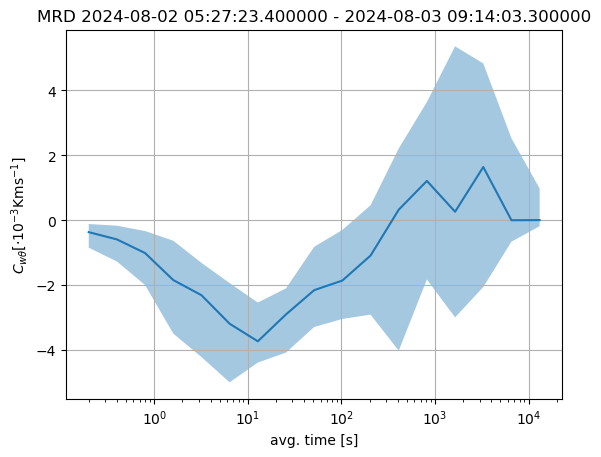

In [19]:
#### 26m tower 
fastdata_rot['time']=fastdata_rot.index
fastdata_rot
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[1000000:2000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [10:31<01:27, 1391.06it/s]


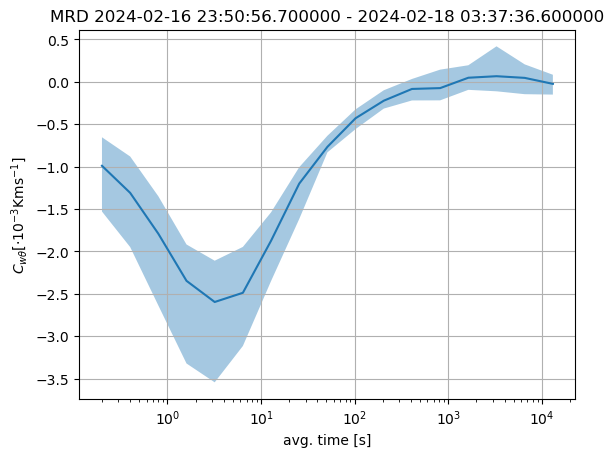

In [ ]:
#### 16m tower
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [06:47<00:56, 2153.35it/s]


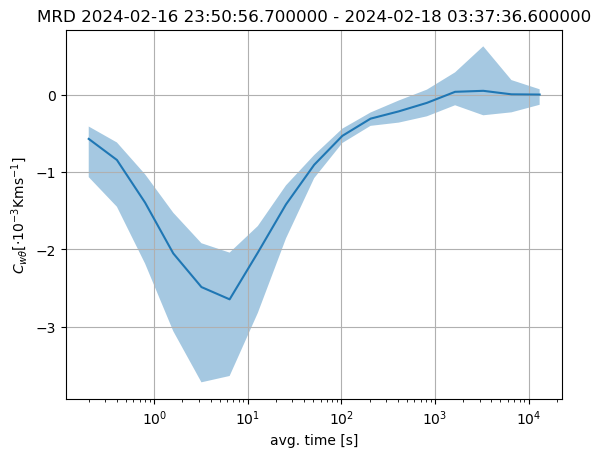

In [7]:
#### 26m tower
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

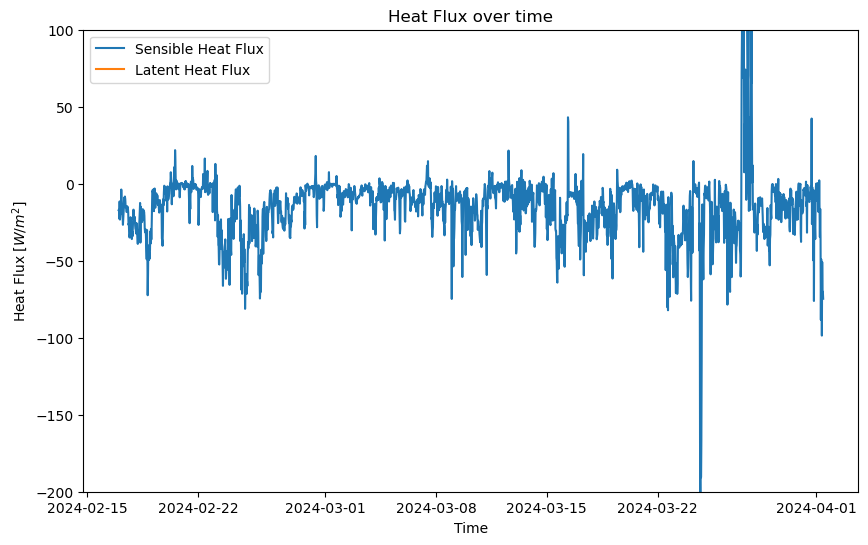

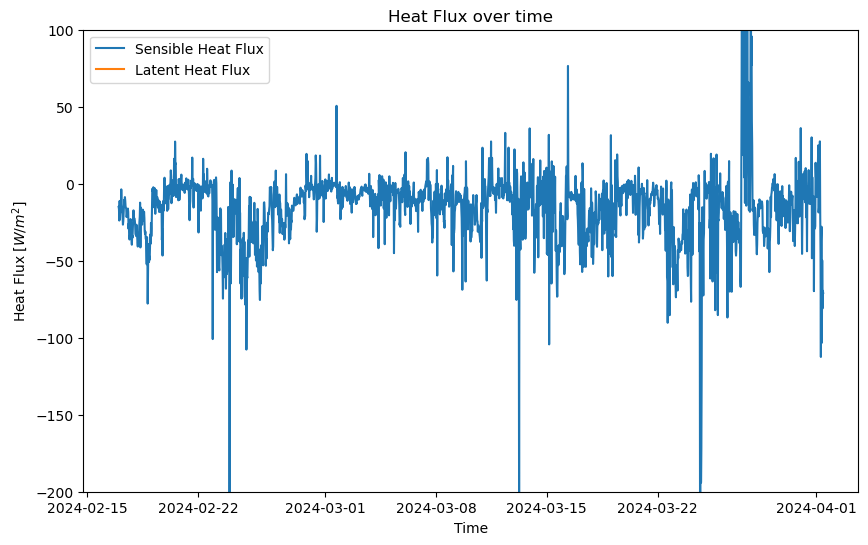

In [12]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '1min', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)

In [29]:
"""PREPROCESS FOR SFC SENSOR"""
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='SFC'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""
slowdata=read_data(folder, 'slow', sensor, start, end, plot_data=False)

#start_file=496
file_numbers_array = [i for i in range(446, 457, 6)]
for file_number in file_numbers_array:
    file_numbers = np.arange(file_number, file_number + 7).astype(int).astype(str)
    print(file_numbers)
    fastdata_SFC=read_data(folder, 'fast', sensor, start, end, file_numbers=file_numbers)

    """DESPIKE AND PLOT FASTDATA"""
    despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, calibration_coefficients=calibration_coefficients, plot_despike=True)

    """SAVE DESPIKED DATA"""
    output_folder='/home/engbers/Documents/PhD/EC_data_convert/SFC/202401'
    save_despiked_data(fastdata_SFC, despiked_fastdata, output_folder, sensor)


Using 2024 calibration coefficients
{'A': 4820.04, 'B': 3792900.0, 'C': -115477000.0, 'H2O_Zero': 0.7087, 'H20_Span': 0.9885}
Reading data from /home/engbers/Documents/PhD/EC_data_convert/converted/20240118_SFC
TOA5_STN1OneMin_403_2023_12_31_1506.dat
TOA5_STN1OneMin_404_2024_01_01_1506.dat
TOA5_STN1OneMin_405_2024_01_02_1506.dat
TOA5_STN1OneMin_406_2024_01_03_1506.dat
TOA5_STN1OneMin_407_2024_01_04_1506.dat
TOA5_STN1OneMin_408_2024_01_05_1506.dat
TOA5_STN1OneMin_409_2024_01_06_1506.dat
TOA5_STN1OneMin_410_2024_01_07_1506.dat
TOA5_STN1OneMin_411_2024_01_08_1506.dat
TOA5_STN1OneMin_412_2024_01_09_1506.dat
TOA5_STN1OneMin_413_2024_01_10_1506.dat
TOA5_STN1OneMin_414_2024_01_11_1506.dat
TOA5_STN1OneMin_415_2024_01_12_1506.dat
TOA5_STN1OneMin_416_2024_01_13_1506.dat
TOA5_STN1OneMin_417_2024_01_14_1506.dat
TOA5_STN1OneMin_418_2024_01_15_1506.dat
TOA5_STN1OneMin_419_2024_01_16_1506.dat
TOA5_STN1OneMin_420_2024_01_17_1506.dat
Reading data from /home/engbers/Documents/PhD/EC_data_convert/convert

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/EC_data_convert/SFC/plots_despiking/EC_despiked_{sensor}_{fastdata.index[0].strftime('%Y%m%d')}.png', bbox_inches='tight')
/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:395: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  


23400
Processing date: 2024-02-05 08:00:00
36000
Processing date: 2024-02-05 09:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_0900.dat
36000
Processing date: 2024-02-05 10:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_1000.dat
36000
Processing date: 2024-02-05 11:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_1100.dat
36000
Processing date: 2024-02-05 12:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_1200.dat
36000
Processing date: 2024-02-05 13:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_1300.dat
36000
Processing date: 2024-02-05 14:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-05_1400.dat
360

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/EC_data_convert/SFC/plots_despiking/EC_despiked_{sensor}_{fastdata.index[0].strftime('%Y%m%d')}.png', bbox_inches='tight')
/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:395: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  


23400
Processing date: 2024-02-10 08:00:00
36000
Processing date: 2024-02-10 09:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_0900.dat
36000
Processing date: 2024-02-10 10:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_1000.dat
36000
Processing date: 2024-02-10 11:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_1100.dat
36000
Processing date: 2024-02-10 12:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_1200.dat
36000
Processing date: 2024-02-10 13:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_1300.dat
36000
Processing date: 2024-02-10 14:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202401/SFC_Fastdata_proc_2024-02-10_1400.dat
360

Plausibility limits: Discarding 2 'u' records.
Plausibility limits: Discarding 2 'v' records.
Plausibility limits: Discarding 3 'w' records.
diag_csat: Discarding 2173 'CSAT' records.
Plausibility limits applied
Applying H2O calibration
Mean H2O concentration difference: 105.16096456888627
H2O calibration applied
Processing large dataset (%)
Spikes removed from Ux,Uy,Uz,Ts:1775 Spikes removed from LI_H2Om_corr:2264


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:221: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/Data/EC_despiked/Figures/EC_despiked_{sensor}.png', bbox_inches='tight')
/home/engbers/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


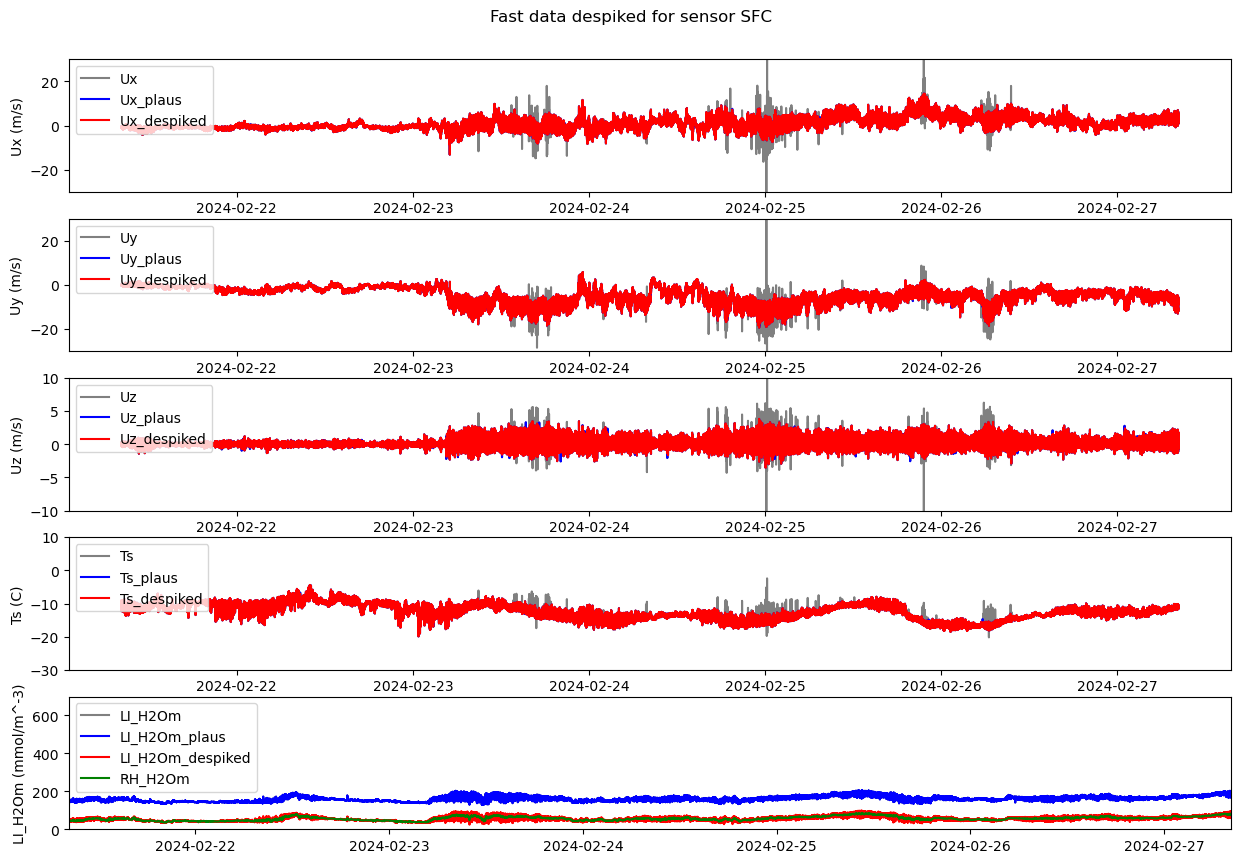

'DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS'

In [3]:
"""DESPIKE AND PLOT FASTDATA"""
despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, calibration_coefficients=calibration_coefficients, plot_despike=True)
# despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, plot_despike=True)

"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
# fastdata_rot, angles=double_rotation(despiked_fastdata)


# """ APPLY MRD TO FIND AVERAGING  TIMESCALE"""

# M=16
# (mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

In [5]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(despiked_fastdata)


# """ APPLY MRD TO FIND AVERAGING  TIMESCALE"""

# M=17
# (mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

Double rotation for blocks of 0 days 00:30:00


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:43: RuntimeWarning: Mean of empty slice
  wmeans_a[i] = np.nanmean(data_a2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:44: RuntimeWarning: Mean of empty slice
  wmeans_b[i] = np.nanmean(data_b2[k:k+l]) #changed mean to nanmean
 88%|████████▊ | 878169/1000000 [07:58<01:06, 1835.49it/s]


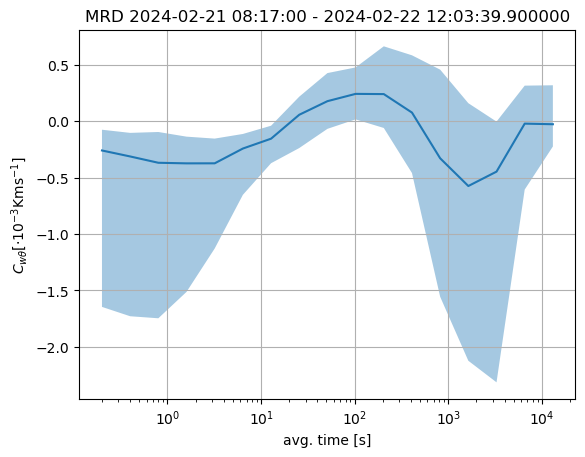

In [10]:
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

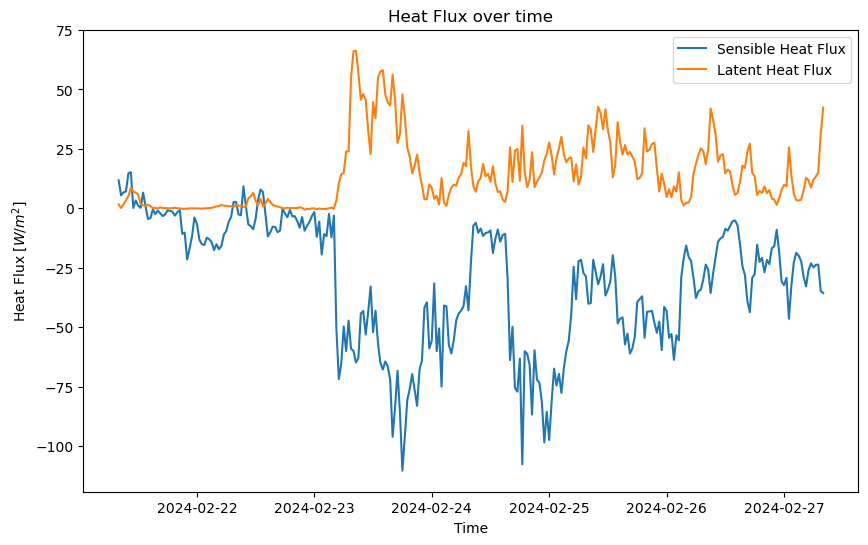

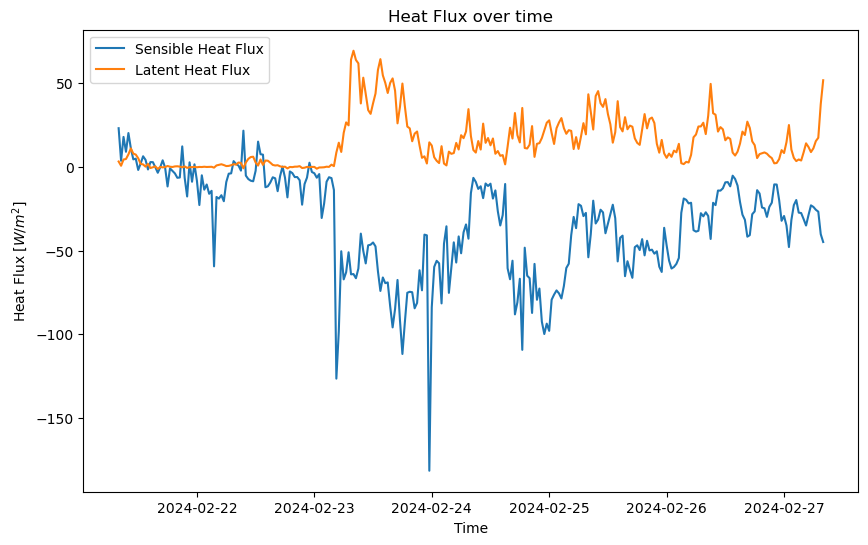

In [11]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '20s', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)

In [26]:
fastdata_rot.to_csv(f'/home/engbers/Documents/PhD/Data/EC_despiked/{folder_name}/fast_{sensor}_{pd.Timestamp(start).strftime('%Y-%m-%d')}_{pd.Timestamp(end).strftime('%Y-%m-%d')}.csv')

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 98%|█████████▊| 1696968/1728600 [04:31<00:05, 6256.52it/s]


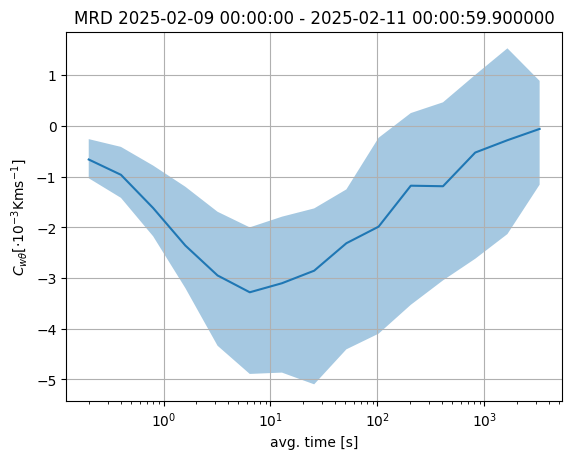

In [305]:
M=15
(mrd_x_1, mrd_data_1, time_middle_1)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)


/tmp/ipykernel_1793656/983133572.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


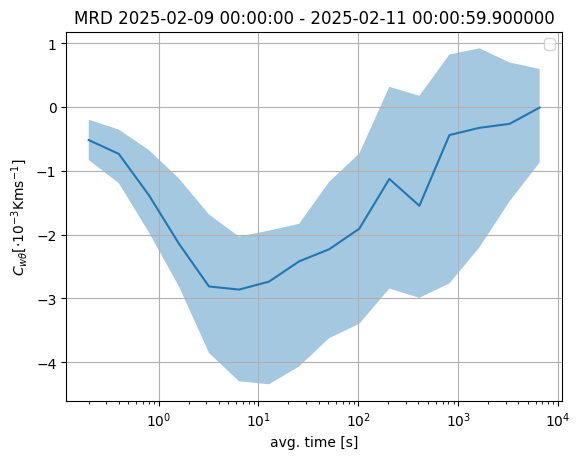

In [ ]:
fig, ax = plt.subplots()

# Set title dynamically using first and last time values from evaldf1
ax.set_title(f"MRD {fastdata_rot.index[0]} - {fastdata_rot.index[-1]}")
ax.set_xlabel("avg. time [s]")
ax.set_ylabel(r"$C_{w\theta} [\cdot 10^{-3} \mathrm{Kms^{-1}}]$")
ax.grid(True)

ax.set_xscale("log")

# Plot the median MRD values
ax.plot(np.array(seconds_array) ,(np.nanmedian(mrd_data_1, axis=1))*1000)

# Fill between the quantiles
ax.fill_between(np.array(seconds_array), 
                np.nanquantile(mrd_data_1, 0.25, axis=1) * 1000, 
                np.nanquantile(mrd_data_1, 0.75, axis=1) * 1000, 
                alpha=0.4)

ax.legend()
plt.show()
